In [195]:

import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
usa = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["United States"])

In [206]:
regions = gpd.read_file('/Users/kamrantehranchi/Local_Documents/pypsa-usa/pypsa-breakthroughenergy-usa/workflow/resources/western/regions_onshore.geojson')
cutout = atlite.Cutout(
    path="/Users/kamrantehranchi/Local_Documents/pypsa-usa/pypsa-breakthroughenergy-usa/workflow/cutouts/cutout_western_era5_2019.nc", module="era5", bounds=regions, time="2019-01"
)

regions = regions.set_index("name").rename_axis("bus")
buses = regions.index

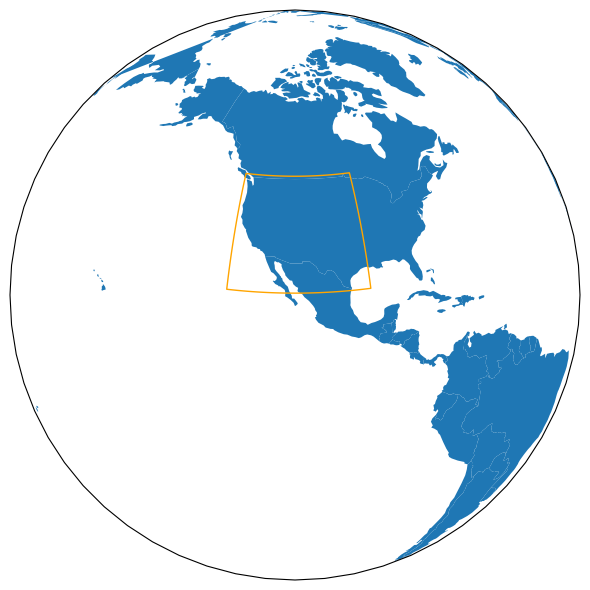

In [197]:
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.Orthographic(-110, 25)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
fig.tight_layout()

# Calculating Land Use Availability


In [237]:
resource = "wind"
correction_factor = 1
capacity_per_sqkm =4.4
p_nom_max_meth = 'potential'

res = 100
excluder = atlite.ExclusionContainer(crs= 5070,res = 100)
# excluder = atlite.ExclusionContainer(crs = 3035, res =100)
# excluder = atlite.ExclusionContainer()

In [238]:
corine = '/Users/kamrantehranchi/Local_Documents/pypsa-usa/pypsa-breakthroughenergy-usa/workflow/data/copernicus/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_USA_EPSG-4326.tif'
codes =  [20, 30, 40, 60, 100, 111, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125, 126]
excluder.add_raster(corine, codes=codes, invert=True, crs=4326)

In [239]:
excluder

Exclusion Container
 registered rasters: 1 
 registered geometry collections: 0
 CRS: 5070 - Resolution: 100

In [240]:
test = regions.loc[["38272"]].geometry.to_crs(excluder.crs)
test.geometry.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [251]:
# masked, transform = excluder.compute_shape_availability(test)
# area = cutout.grid.to_crs(excluder.crs).area / 1e6
# area = xr.DataArray(
#     area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
# )
# area.sum()

# eligible_share = masked.sum() * excluder.res**2 / area
# print(f"The eligibility share is: {eligible_share.sum():.2%}")

<Axes: title={'center': 'Eligible area (green) 97.93%'}>

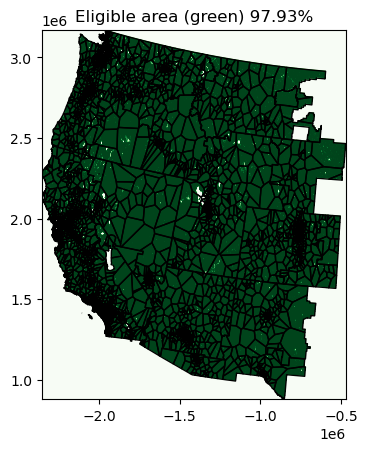

In [236]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(regions)

In [224]:
no_progress = True
kwargs = dict(nprocesses=4, disable_progressbar=no_progress)
if no_progress:
    print("Calculate landuse availabilities...")
    availability = cutout.availabilitymatrix(regions, excluder, **kwargs)
else:
    availability = cutout.availabilitymatrix(regions, excluder, **kwargs)

Compute availability matrix: 100%|██████████| 4761/4761 [06:58<00:00, 11.38 gridcells/s]


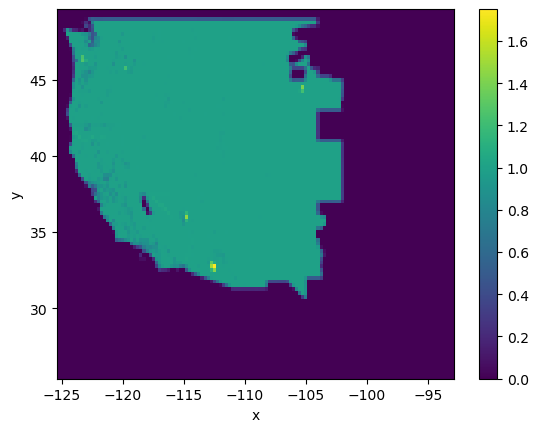

In [250]:
availability.sum("bus").plot()

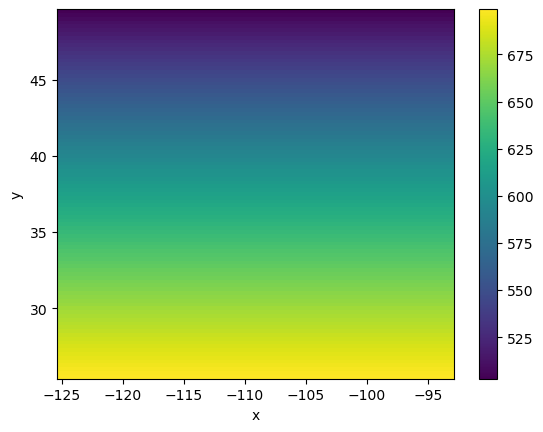

In [258]:
area = cutout.grid.to_crs("ESRI:54009").area / 1e6
# area = cutout.grid.to_crs({'proj':'cea'}).area / 1e6
area = xr.DataArray(
    area.values.reshape(cutout.shape), [cutout.coords["y"], cutout.coords["x"]]
)
area.plot()

In [242]:
potential = capacity_per_sqkm * availability.sum("bus") * area

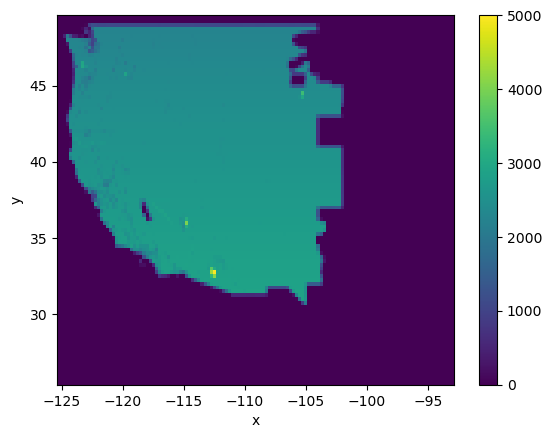

In [245]:
potential.plot()

## Plot Cutout Data

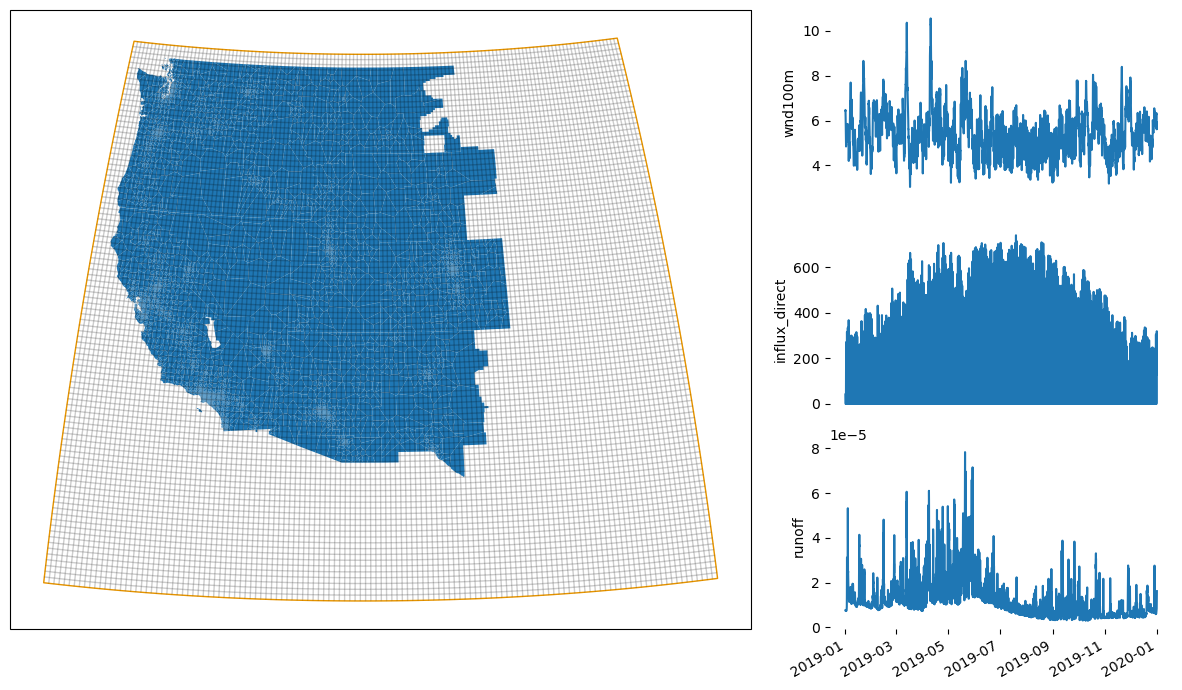

In [200]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection, aspect =1)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect=1,
    facecolor="None",
    transform=plate(),
)
regions.plot(ax=ax, zorder=1, aspect =1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
# ax.outline_patch.set_edgecolor("white")

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(["x", "y"]).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()
plt.show()


## Simulate Wind

INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 114.07 s


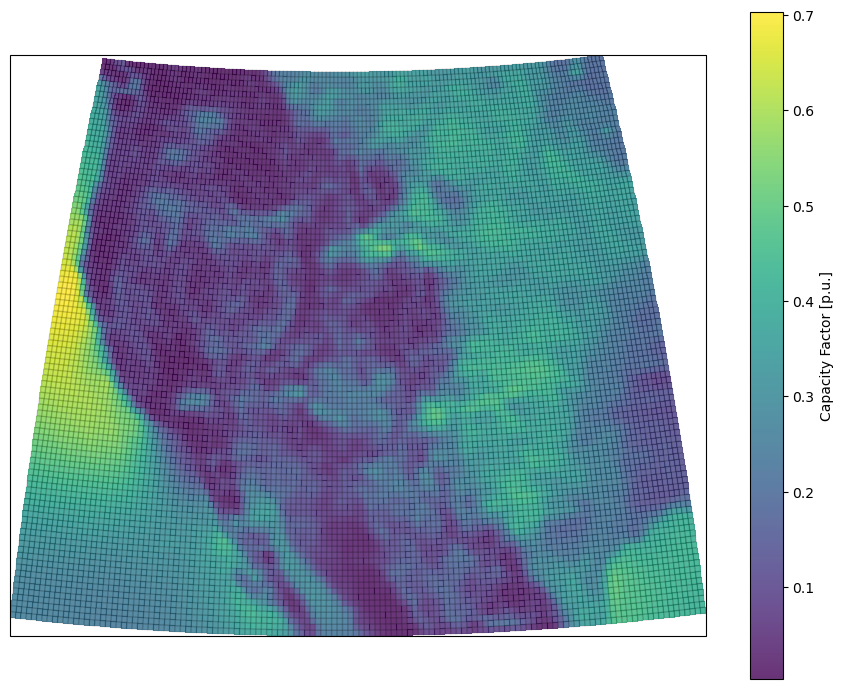

In [6]:
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(9, 7))
cap_factors.name = "Capacity Factor"
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
# ax.outline_patch.set_edgecolor("white")
fig.tight_layout();